### `UR5e` and `RG2` gripper with objects and a table

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.6]


### Parse `scene_ur5e_rg2_obj.xml`

In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e',rel_xml_path=xml_path,VERBOSE=True)

dt:[0.0020] HZ:[500]
n_dof (=nv):[60]
n_geom:[52]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[29]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylin

### Set objects

In [3]:
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects
xyzs = sample_xyzs(
    n_sample=n_obj,x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2,xy_margin=0.05)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
colors[:,3] = 1.0 # transparent objects
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color
# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8]) # robot base
for body_name in ['base_table','front_object_table','side_object_table']:
    geomadr = env.model.body(body_name).geomadr[0]
    env.model.geom(geomadr).rgba[3] = 1.0
print ("Ready.")

Ready.


### Loop

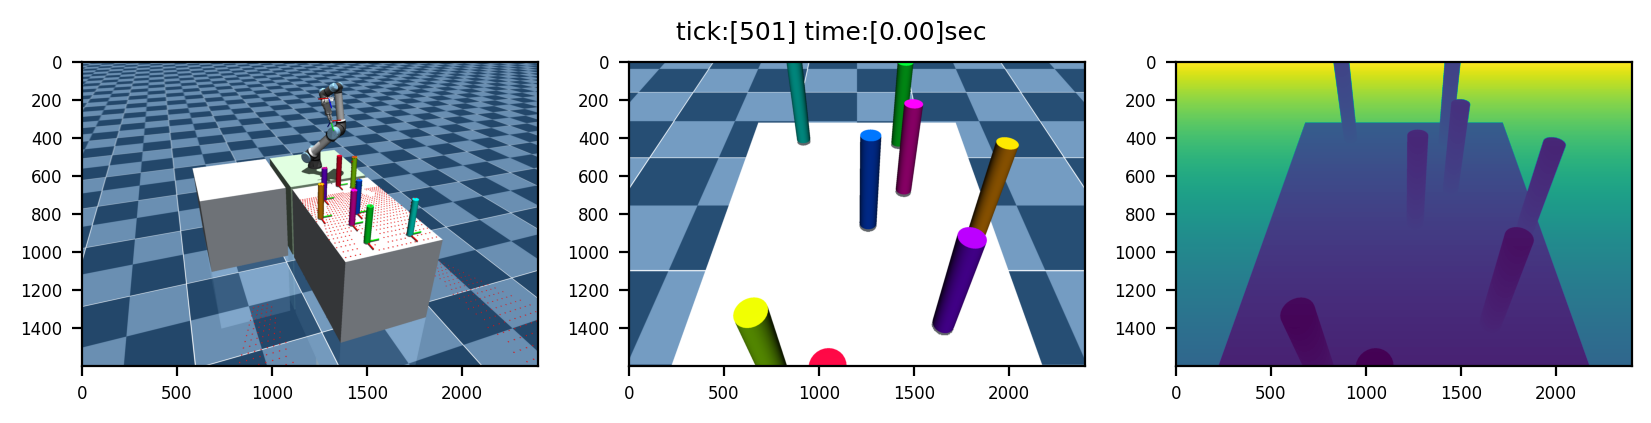

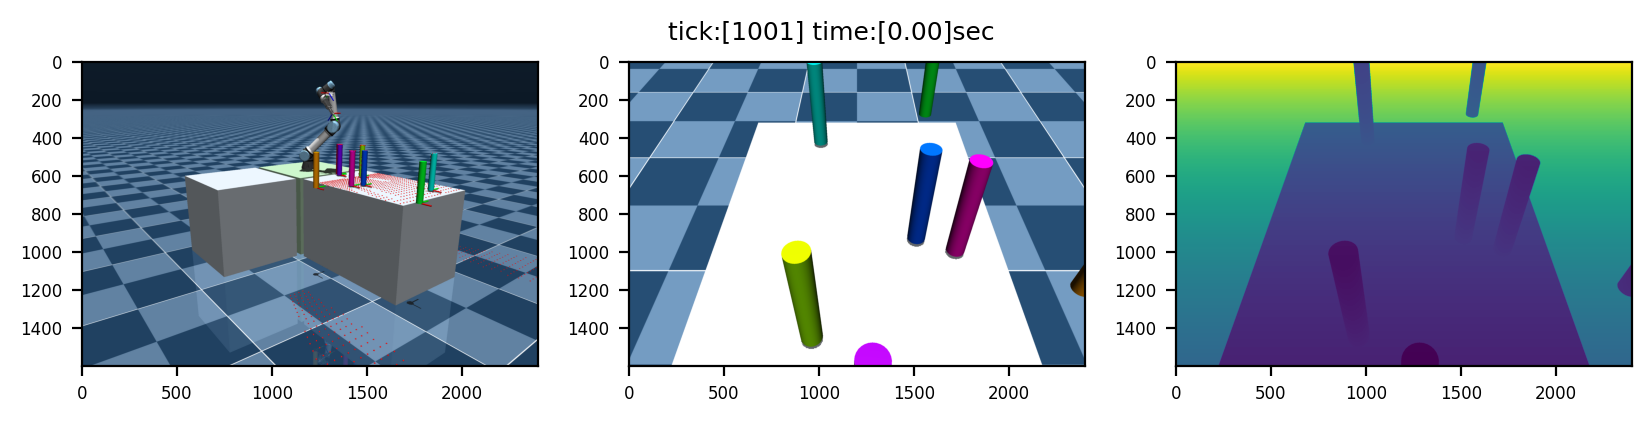

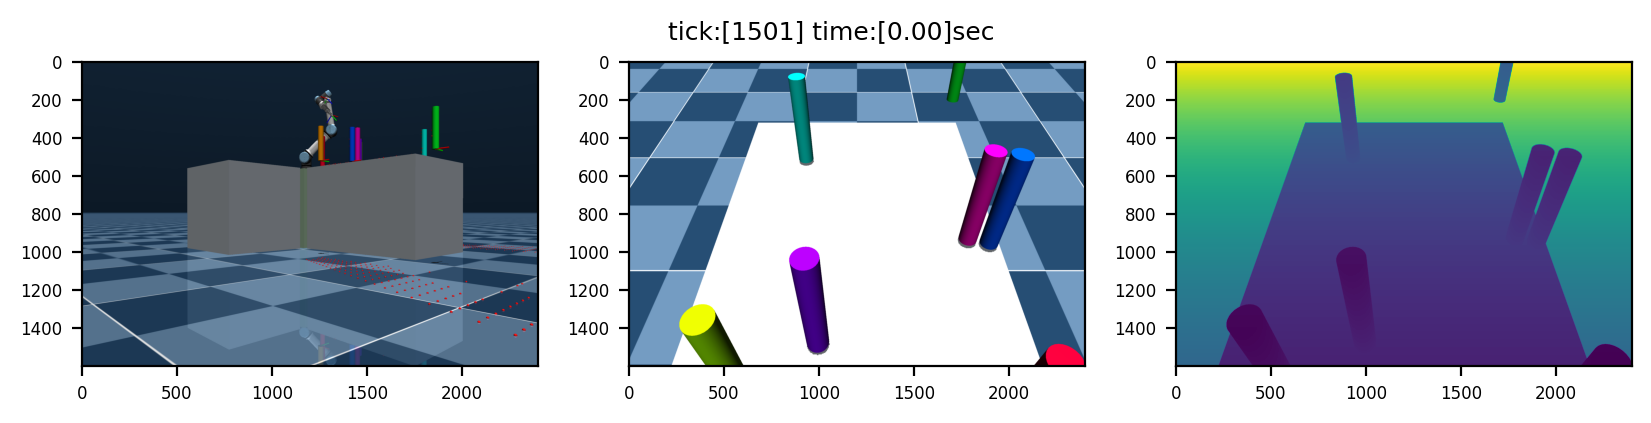

Pressed ESC
Quitting.


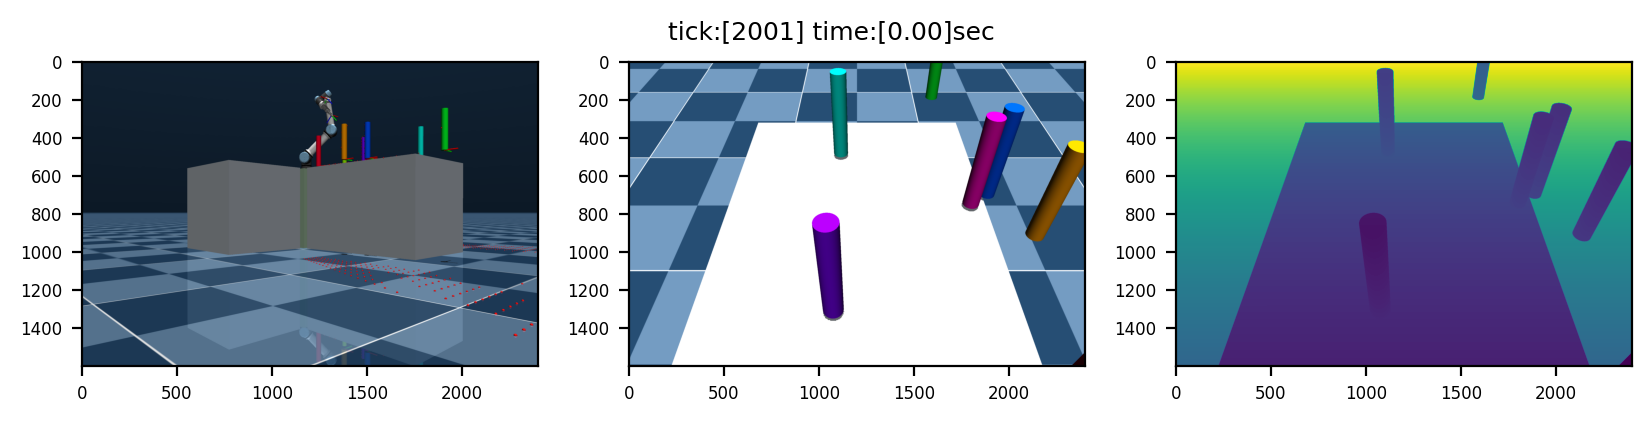

Done.


In [5]:
env.init_viewer(viewer_title='UR5e with RG2',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=160,distance=4.00,elevation=-30,lookat=[0.2,-0.13,0.34],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,
                  jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

# Joint indices
rev_joint_names = ['shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
                   'wrist_1_joint','wrist_2_joint','wrist_3_joint']
idxs_ur_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
idxs_ur_jac = env.get_idxs_jac(joint_names=rev_joint_names)
idxs_ur_step = env.get_idxs_step(joint_names=rev_joint_names)

# Initialize pose
p_base = env.get_p_body(body_name='base')
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,45,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_init = env.solve_ik(
    body_name='tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),rev_joint_idxs=idxs_ur_jac,
    RESET=False,DO_RENDER=False,render_every=1,th=1*np.pi/180.0,err_th=1e-4)
env.forward(q=q_init,joint_idxs=idxs_ur_fwd)

FIRST_FLAG = True
while env.is_viewer_alive():
    
    # Modify the properties of objects
    for obj_name in obj_names:
        geomadr = env.model.body(obj_name).geomadr[0]
        # change size
        geom_size = env.model.geom_size[geomadr,:]
        geom_size[0] = geom_size[0] + 0.0 # increase the radius of cylnder
        geom_size[1] = geom_size[1] + 0.0 # increase the height of cylnder
        env.model.geom_size[geomadr,:] = geom_size
        # change position
        jntadr  = env.model.body(obj_name).jntadr[0]
        qposadr = env.model.jnt_qposadr[jntadr]
        geom_pos = env.data.qpos[qposadr:qposadr+3]
        geom_pos[:2] = geom_pos[:2] + 0.005*np.random.randn(2)
        env.data.qpos[qposadr:qposadr+3] = geom_pos
        env.data.qpos[qposadr+3:qposadr+7] = r2quat(rpy2r(np.radians([0,0,0])))
        
    # Step
    # env.step(ctrl=np.append(q_init,1.0),ctrl_idxs=idxs_ur_step+[6])
    env.forward()
    
    # Get camera observation
    if env.loop_every(HZ=10) or FIRST_FLAG:
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=50,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
    
    # Render
    if env.loop_every(HZ=20) or FIRST_FLAG:
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
        env.plot_body_T(body_name='tcp_link',PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_body_T(body_name='camera_center',PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        for obj_name in obj_names:
            env.plot_body_T(obj_name,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        # env.plot_contact_info(VERBOSE=False) # plot contanct information
        for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        env.render(render_every=1)
    
    # Plot world view and egocentric RGB and depth images
    if env.loop_every(HZ=1) and env.get_sim_time() <= 3.0:
        fig,axs = plt.subplots(1,3,figsize=(10,2))
        scene_img = env.grab_image()
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
        plt.subplots_adjust(wspace=0.2); plt.show()

    # Clear flag
    FIRST_FLAG = False

env.close_viewer()
print ("Done.")